## Joscelind Oosthuizen
## ST10068012

## RPDA8412 Research project

- dataset: https://research.unsw.edu.au/projects/bot-iot-dataset 

In [ ]:
# Setup and imports
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Data + results paths - change if necessary
DATA_PATH = "UNSW_2018_IoT_Botnet_Final_10_Best.csv"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# ML / Data libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# plotting
import matplotlib.pyplot as plt

# libraries (SMOTE, psutil)
try:
    from imblearn.over_sampling import SMOTE
    HAVE_SMOTE = True
except Exception:
    HAVE_SMOTE = False

try:
    import psutil
    HAVE_PSUTIL = True
except Exception:
    HAVE_PSUTIL = False

print("Setup complete. DATA_PATH =", DATA_PATH)
print("SMOTE available:", HAVE_SMOTE, "psutil available:", HAVE_PSUTIL)


Setup complete. DATA_PATH = UNSW_2018_IoT_Botnet_Final_10_Best.csv
SMOTE available: True psutil available: True


This section sets up the environment, loads essential libraries, and prepares paths needed for the machine learning workflow. It begins by importing core Python utilities such as os, time, and warnings, which are used to manage files, measure execution time, and suppress unnecessary warnings. The code then defines where the dataset is stored and where all results will be saved, automatically creating a results directory if it does not already exist. Next, the main machine learning libraries are imported. NumPy and Pandas handle numerical operations and dataset processing. Scikit-learn tools are used for splitting the data (train_test_split), performing stratified cross-validation (StratifiedKFold), and scaling features (StandardScaler). The metrics imported including accuracy, precision, recall, F1-score, confusion matrix, and ROC AUC allow for a comprehensive evaluation of model performance. The three lightweight machine learning algorithms used in this study Logistic Regression, Decision Tree, and Gaussian Naïve Bayes are also imported for training and comparison. Matplotlib is included to generate visualisations such as confusion matrices and ROC curves. The final part of the code attempts to import optional libraries: SMOTE from Imbalanced-learn, which handles class imbalance, and psutil, which measures CPU and memory usage. The code checks whether these libraries are available and prints their availability status to ensure smooth execution. This structured setup ensures that all required tools for preprocessing, modelling, evaluation, and resource measurement are loaded correctly before analysis begins (GeeksforGeeks, 2025).

In [ ]:
# Load CSV and preview
df = pd.read_csv(DATA_PATH, sep=';', engine='python')
print("Raw dataframe shape:", df.shape)
display(df.head(6))
display(df.columns.tolist())


Raw dataframe shape: (3668522, 20)


,Unnamed: 0,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,0,1,tcp,192.168.100.147,49960,192.168.100.7,80,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,1,DoS,HTTP
1,1,2,arp,192.168.100.7,-1,192.168.100.147,-1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,1,DoS,HTTP
2,2,3,tcp,192.168.100.147,49962,192.168.100.7,80,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,1,DoS,HTTP
3,3,4,tcp,192.168.100.147,49964,192.168.100.7,80,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,1,DoS,HTTP
4,4,5,tcp,192.168.100.147,49966,192.168.100.7,80,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,1,DoS,HTTP
5,5,6,tcp,192.168.100.147,49968,192.168.100.7,80,14,0.063579,75,0.000000,1,0.063579,96,15.728587,0.567650,0.127157,1,DoS,HTTP


['Unnamed: 0',
 'pkSeqID',
 'proto',
 'saddr',
 'sport',
 'daddr',
 'dport',
 'seq',
 'stddev',
 'N_IN_Conn_P_SrcIP',
 'min',
 'state_number',
 'mean',
 'N_IN_Conn_P_DstIP',
 'drate',
 'srate',
 'max',
 'attack',
 'category',
 'subcategory']

This section loads the dataset into a Pandas DataFrame and provides an initial preview to understand its structure and content. The CSV file is read using pd.read_csv(), with the separator explicitly set to a semicolon (sep=';') because the BoT-IoT dataset is not comma-delimited. The engine='python' parameter ensures compatibility with complex delimiters. After loading, the code prints the raw shape of the dataset to show the number of rows and columns, helping verify that the file was imported correctly. Using df.head(6), the first six rows of data are displayed, offering a snapshot of what the dataset contains, including source and destination IPs, port numbers, statistical features such as mean and standard deviation, and the attack labels. This early inspection assists in identifying potential issues such as placeholder values, negative port numbers, or irrelevant index columns. The final line lists all column names, enabling quick verification of the dataset's feature set before further preprocessing and modelling steps (GeeksforGeeks, 2025).

- Evaluation of the Output: The output confirms that the dataset loaded successfully with 3,668,522 rows and 20 columns, consistent with the expected structure of the curated BoT-IoT subset. The preview shows that the first column (Unnamed: 0) appears to be an unnecessary index column that can be dropped later. The presence of negative values in fields like sport and dport suggests placeholder values used for non-TCP/UDP protocols such as ARP, which is normal for this dataset and will need cleaning or encoding during preprocessing. The columns list confirms the inclusion of key network flow attributes and attack categories, verifying that the data contains both feature variables and labels required for supervised classification. Overall, the output indicates that the dataset is ready for further exploration and cleaning.

In [ ]:
# Clean column names and inspect target distribution
df.columns = [c.strip() for c in df.columns]
print("Columns after strip:", df.columns.tolist())

# Ensure attack column exists
if 'attack' not in df.columns:
    raise ValueError("No 'attack' column found. Check your CSV header.")

# Check unique values in 'attack' and distribution
print("Unique attack values:", df['attack'].unique())
print(df['attack'].value_counts(dropna=False))


Columns after strip: ['Unnamed: 0', 'pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Unique attack values: [1 0]
attack
1    3668045
0        477
Name: count, dtype: int64


This section prepares the dataset by cleaning column names and confirming that the target variable is present. All column names are stripped of whitespace to avoid referencing errors during preprocessing and modelling. The cleaned list is printed to verify that the operation was successful. The script then checks for the presence of the attack column essential for the classification task and raises an error if it is missing. This type of validation is a standard and necessary step in machine learning workflows to ensure data integrity before analysis (GeeksforGeeks, 2025). Next, the code inspects the unique values and distribution within the attack column. This allows the researcher to understand the balance between malicious (1) and benign (0) traffic.

- Evaluation of the Output: The output shows that all column names were cleaned correctly, and the attack column is present. The dataset contains a binary target with values [1, 0]. The distribution is extremely imbalanced, with 3,668,045 attack records and only 477 benign records. This confirms that the dataset is heavily skewed and will require techniques such as stratified sampling or SMOTE to handle the imbalance before modelling.

Performing Exploratory Data Analysis...

Dataset Shape: (3668522, 20)

First 5 rows:


,Unnamed: 0,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,0,1,tcp,192.168.100.147,49960,192.168.100.7,80,9,0.068909,75,0.000000,1,0.068909,96,14.511893,0.566862,0.137818,1,DoS,HTTP
1,1,2,arp,192.168.100.7,-1,192.168.100.147,-1,10,0.000000,2,0.000131,2,0.000131,1,0.000000,0.000000,0.000131,1,DoS,HTTP
2,2,3,tcp,192.168.100.147,49962,192.168.100.7,80,11,0.064494,75,0.000000,1,0.064494,96,15.505319,0.567549,0.128988,1,DoS,HTTP
3,3,4,tcp,192.168.100.147,49964,192.168.100.7,80,12,0.064189,75,0.000000,1,0.064189,96,15.578993,0.567570,0.128378,1,DoS,HTTP
4,4,5,tcp,192.168.100.147,49966,192.168.100.7,80,13,0.063887,75,0.000000,1,0.063887,96,15.652637,0.567630,0.127774,1,DoS,HTTP



Descriptive Statistics:


,Unnamed: 0,pkSeqID,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
count,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06,3.668522e+06
mean,1.834260e+06,1.834262e+06,1.213204e+05,8.871499e-01,8.253848e+01,1.017540e+00,3.134390e+00,2.231063e+00,9.245168e+01,4.455046e-01,2.955111e+00,3.020015e+00,9.998700e-01
std,1.059011e+06,1.059011e+06,7.579428e+04,8.037139e-01,2.439739e+01,1.483688e+00,1.186971e+00,1.517728e+00,1.817643e+01,6.028863e+01,7.245425e+02,1.860877e+00,1.140212e-02
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.171302e+05,9.171312e+05,5.487600e+04,3.001900e-02,6.900000e+01,0.000000e+00,3.000000e+00,1.819670e-01,1.000000e+02,0.000000e+00,1.559700e-01,2.806072e-01,1.000000e+00
50%,1.834260e+06,1.834262e+06,1.177690e+05,7.938960e-01,1.000000e+02,0.000000e+00,4.000000e+00,2.690125e+00,1.000000e+02,0.000000e+00,2.837830e-01,4.009111e+00,1.000000e+00
75%,2.751391e+06,2.751392e+06,1.849300e+05,1.745296e+00,1.000000e+02,2.151138e+00,4.000000e+00,3.565203e+00,1.000000e+02,0.000000e+00,4.882010e-01,4.293582e+00,1.000000e+00
max,3.668521e+06,3.668522e+06,2.622120e+05,2.496763e+00,1.000000e+02,4.980471e+00,1.100000e+01,4.981882e+00,1.000000e+02,5.882353e+04,1.000000e+06,4.999999e+00,1.000000e+00


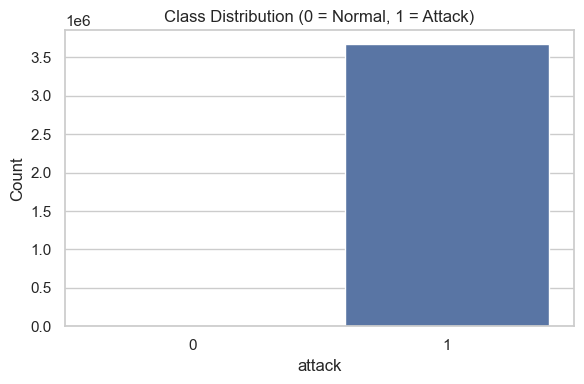


Class Distribution:
attack
1    3668045
0        477
Name: count, dtype: int64


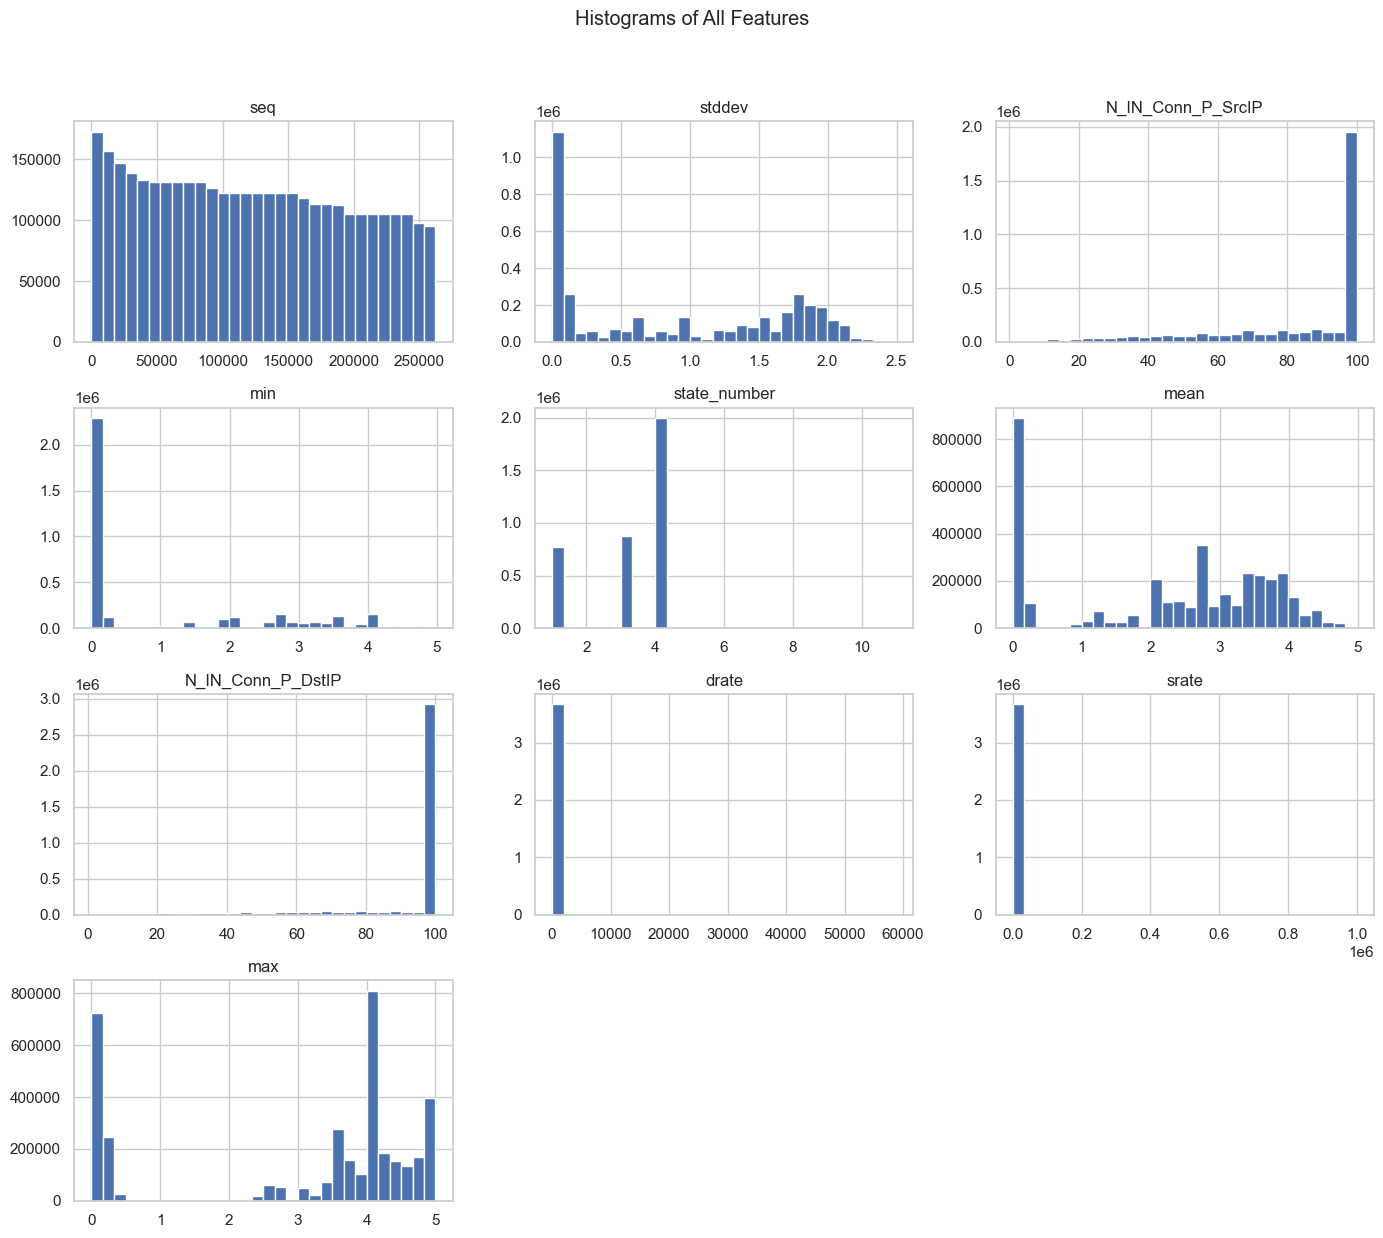

<Figure size 1400x1000 with 0 Axes>

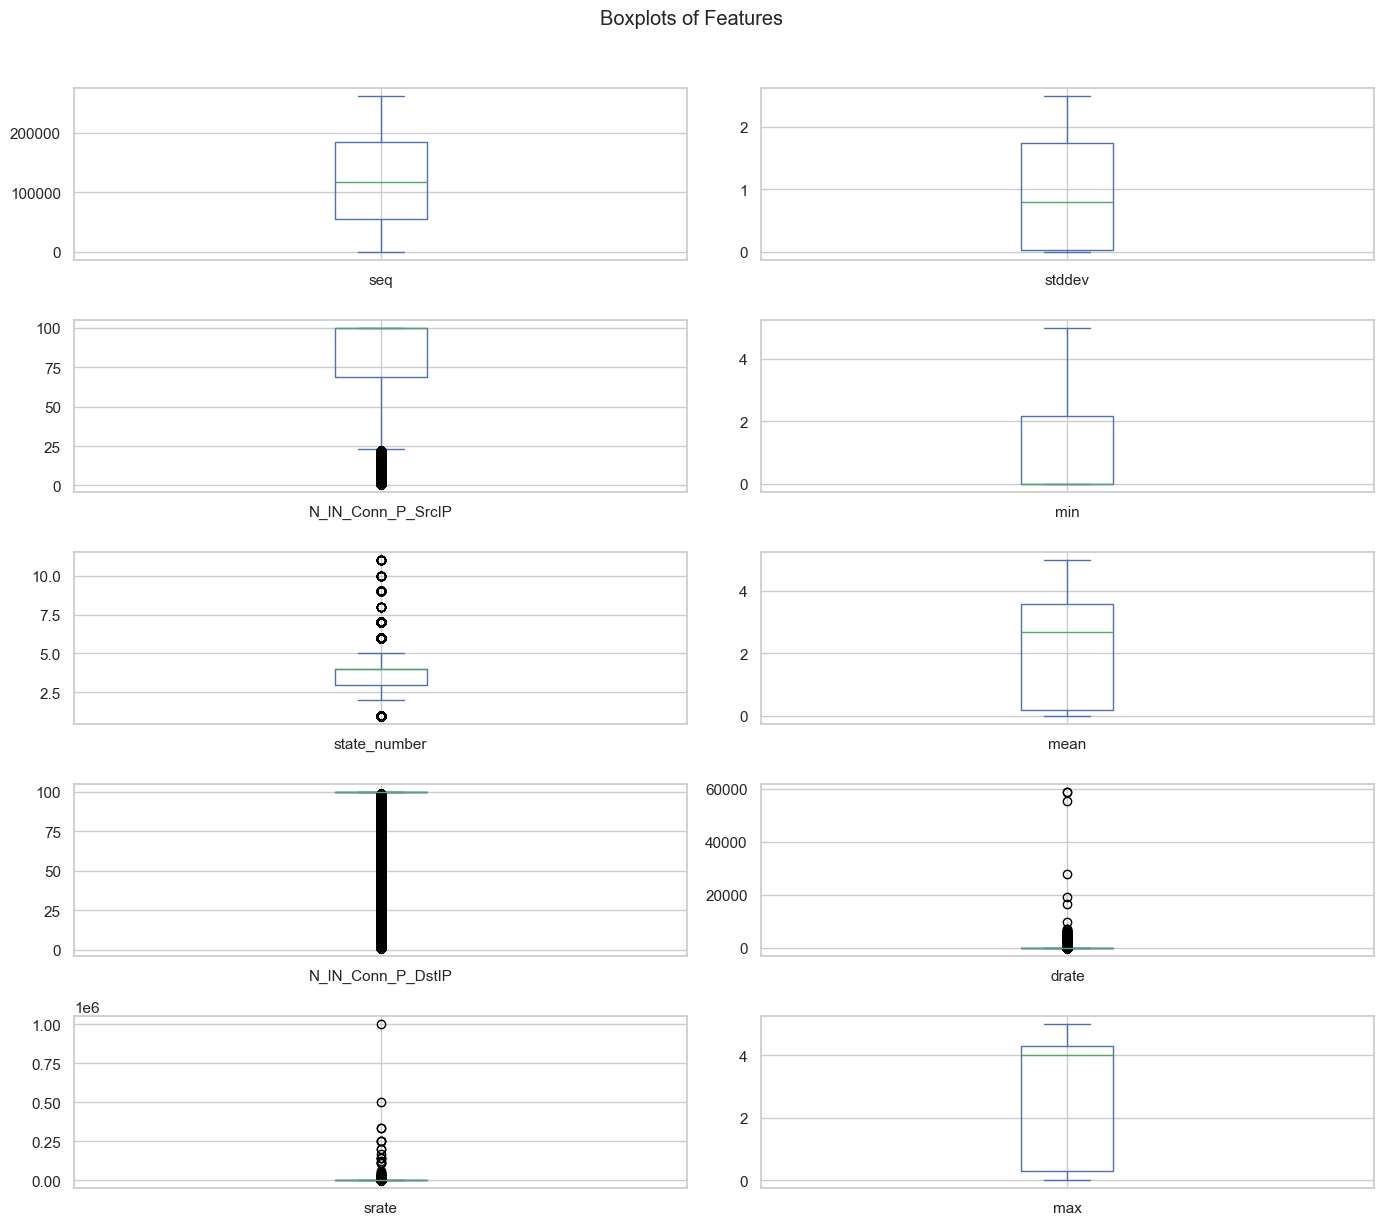

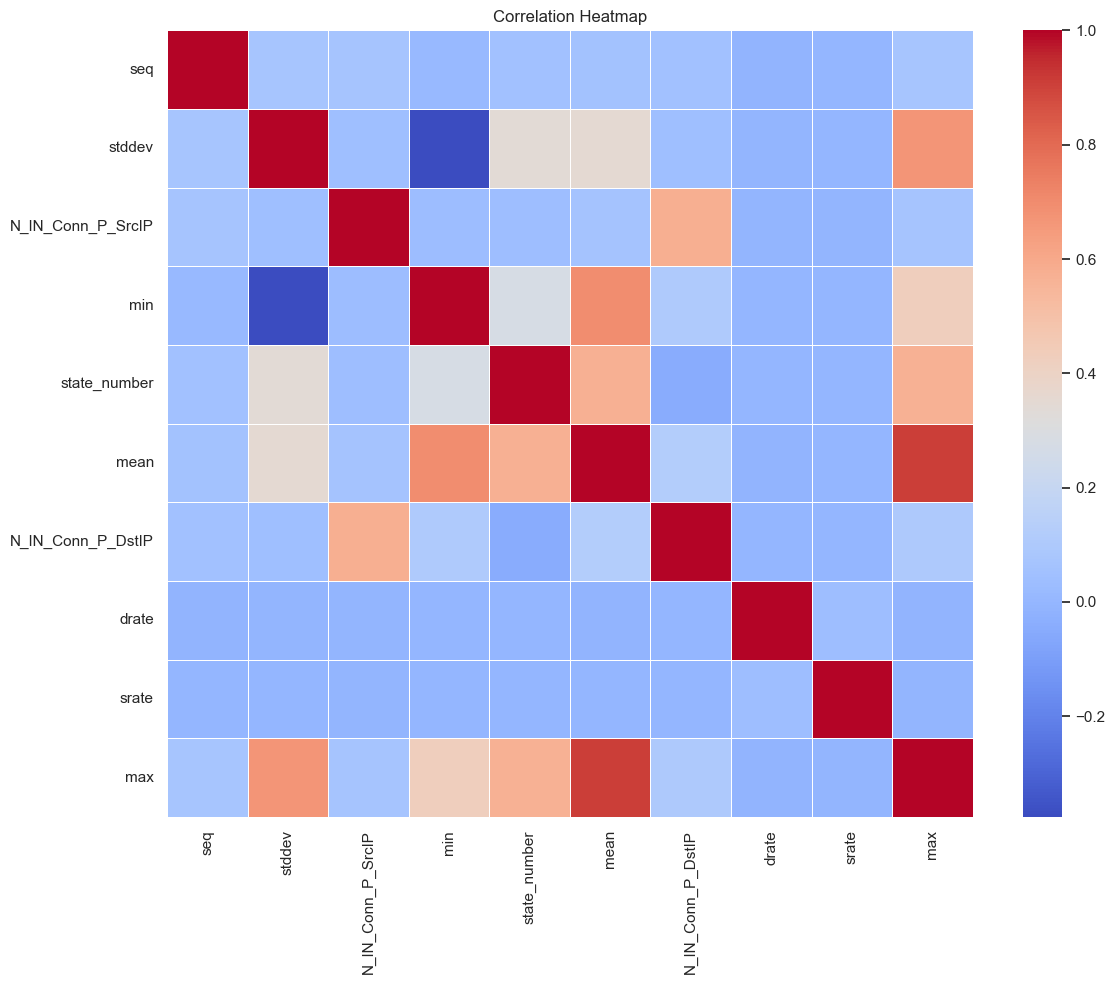

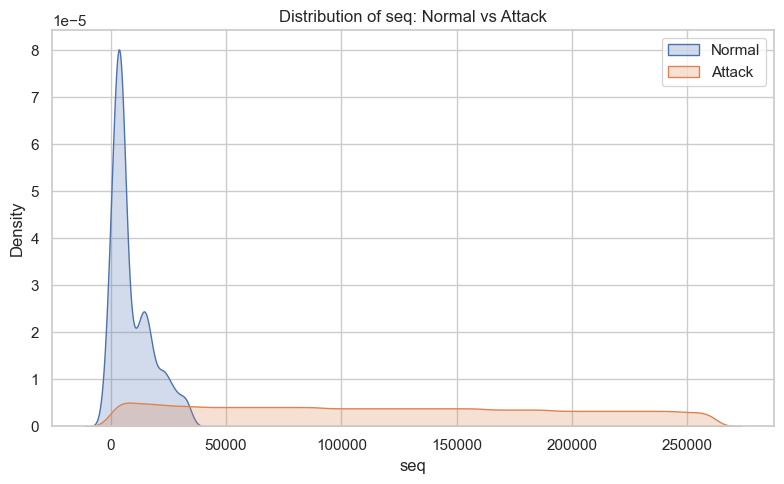

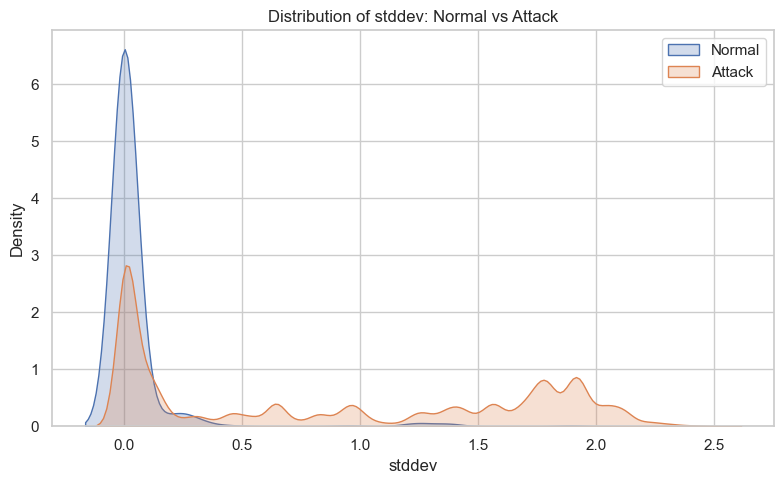

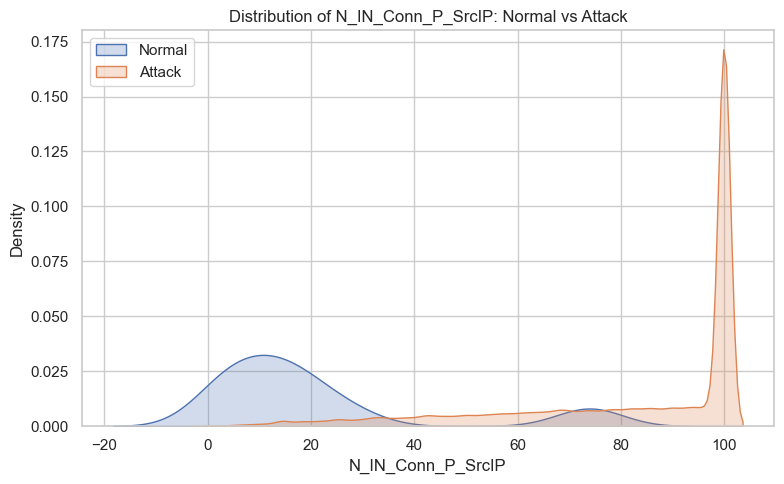

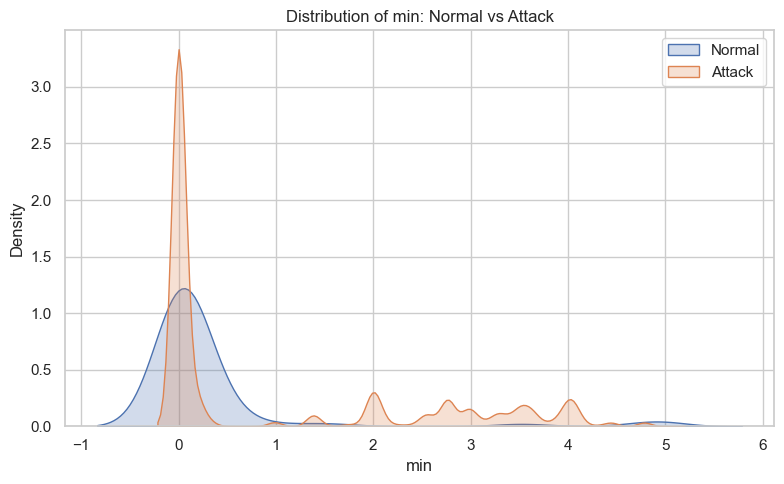

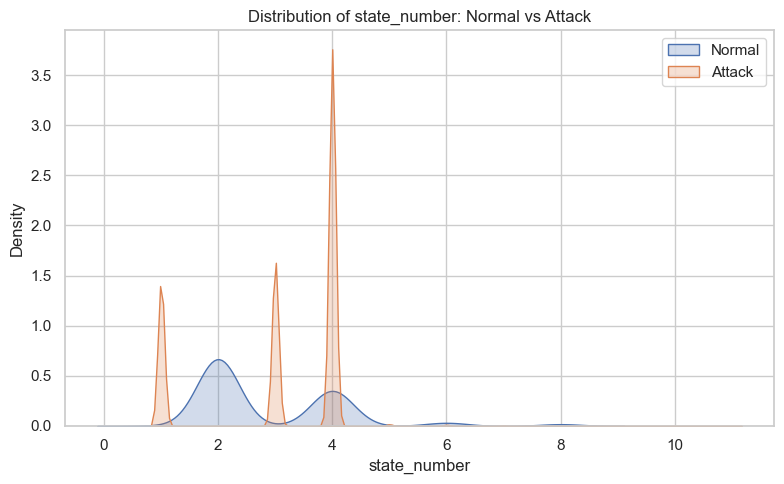

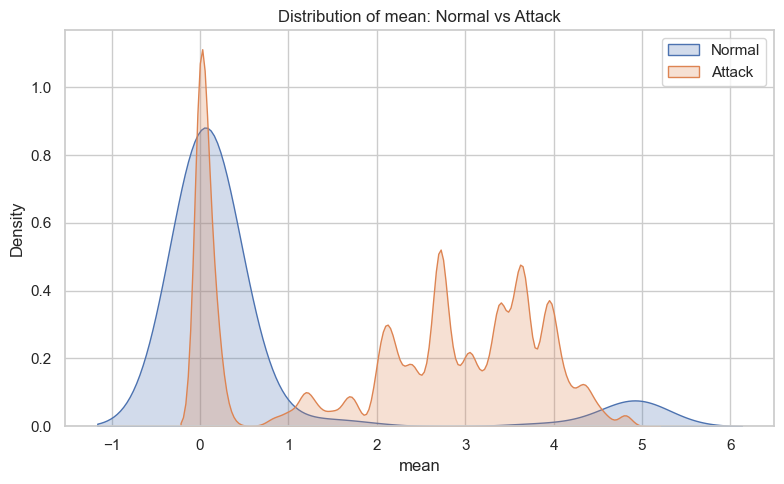

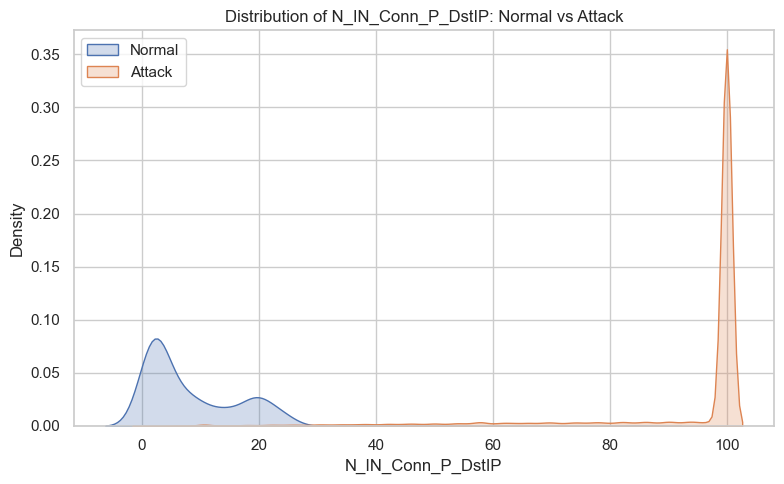

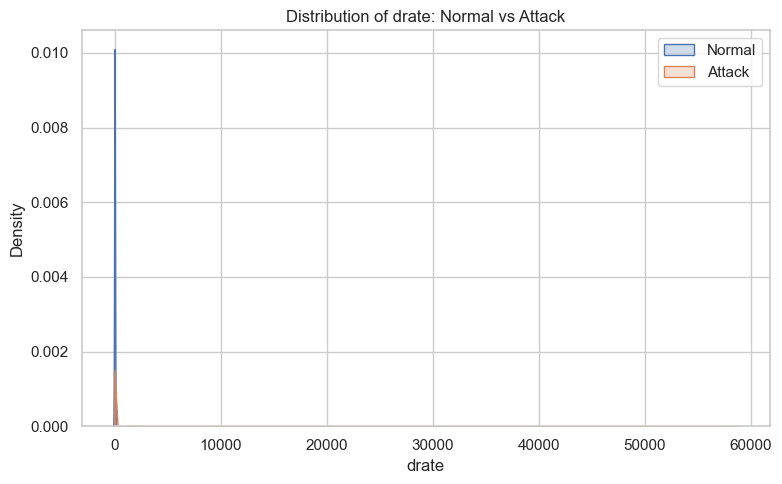

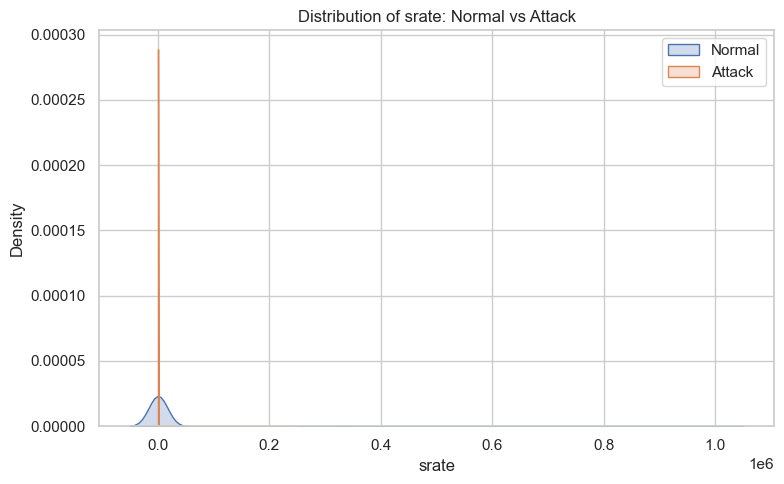

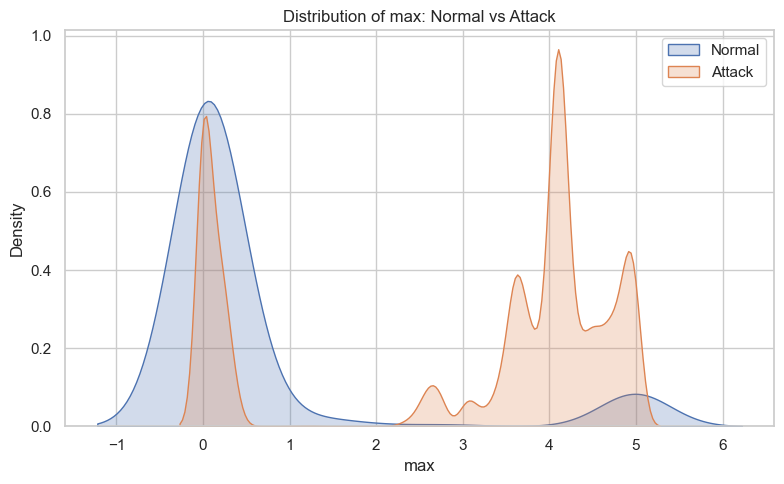


EDA Completed. All plots saved to: results


In [ ]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

print("Performing Exploratory Data Analysis...\n")

# Dataset Overview

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nDescriptive Statistics:")
display(df.describe())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df["attack"])
plt.title("Class Distribution (0 = Normal, 1 = Attack)")
plt.xlabel("attack")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "class_distribution.png"))
plt.show()

print("\nClass Distribution:")
print(df["attack"].value_counts())


# Histograms for All Features

df[features].hist(figsize=(14, 12), bins=30)
plt.suptitle("Histograms of All Features", y=1.03)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "histograms_all_features.png"))
plt.show()


# Boxplots for Detecting Outliers

plt.figure(figsize=(14, 10))
df[features].plot(kind='box', subplots=True, layout=(5, 2),
                  figsize=(14, 12), sharex=False, sharey=False)
plt.suptitle("Boxplots of Features", y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "boxplots_all_features.png"))
plt.show()


# Correlation Heatmap

plt.figure(figsize=(12, 10))
corr = df[features].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "correlation_heatmap.png"))
plt.show()

# Distribution Plots: Normal vs Attack

attack_df = df[df["attack"] == 1]
normal_df = df[df["attack"] == 0]

for col in features:
    plt.figure(figsize=(8,5))
    sns.kdeplot(normal_df[col], label="Normal", shade=True)
    sns.kdeplot(attack_df[col], label="Attack", shade=True)
    plt.title(f"Distribution of {col}: Normal vs Attack")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f"distplot_{col}.png"))
    plt.show()

print("\nEDA Completed. All plots saved to:", RESULTS_DIR)


The Exploratory Data Analysis (EDA) begins by printing the dataset’s shape and displaying the first five rows, giving an initial understanding of the structure, number of features, and types of values present. Descriptive statistics are then generated to summarise the central tendency and spread of all numerical variables, helping identify unusual ranges or potential data quality issues. A class distribution plot reveals a highly imbalanced dataset, with 3,668,045 attack records and only 477 normal records, indicating the need for resampling techniques such as SMOTE. Histograms for all features provide an overview of the value distributions, while boxplots help detect outliers that may influence model performance. A correlation heatmap is used to examine relationships between features and highlight redundancy or multicollinearity. Finally, kernel density plots compare how each feature behaves in normal versus attack traffic, showing clear separation in some variables and heavy overlap in others; this helps determine which features are most discriminative. Overall, the EDA reveals an extremely imbalanced dataset, potential outliers, varying feature distributions, and feature correlations all essential insights for guiding preprocessing and model development (GeekforGeeks, 2025).

In [ ]:
# Select the 10 features you specified in your proposal
features = ['seq','stddev','N_IN_Conn_P_SrcIP','min','state_number',
            'mean','N_IN_Conn_P_DstIP','drate','srate','max']

# Confirm features exist
missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"Missing expected feature columns: {missing}")

X = df[features].copy()
y = df['attack'].copy()  # attack is numeric in your sample (1 for attack, 0 for benign)

# Basic cleaning: replace inf/nan and cast to float
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())
X = X.astype(float)

print("X shape:", X.shape, "y shape:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True))


X shape: (3668522, 10) y shape: (3668522,)
Class distribution:
 attack
1    0.99987
0    0.00013
Name: proportion, dtype: float64


The code first selects the ten features defined in the research proposal and verifies that each of these variables exists in the dataset to prevent errors during model development. The feature matrix X is then created using these selected columns, while the target vector y is extracted from the attack field, which is already encoded as 1 for attack traffic and 0 for normal traffic. To ensure data quality, the code replaces infinite values with NaN, fills all missing values using the median of each feature, and converts the dataset to a consistent floating-point format suitable for machine learning algorithms. The output confirms that the final dataset contains 3,668,522 rows and 10 selected features, matching the target vector in size. The class distribution reveals an extreme imbalance, with 99.987% attack samples and only 0.013% normal samples, indicating that specialised techniques such as resampling or class-balanced modelling will be required later to avoid biased predictions.

In [ ]:
# Train/test split (stratified) and SMOTE

RANDOM_STATE = 42
TEST_SIZE = 0.30

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class dist:\n", y_train.value_counts(normalize=True))

# Optionally balance training set with SMOTE
USE_SMOTE = True  # set False to skip
if USE_SMOTE and HAVE_SMOTE:
    print("Before SMOTE:", y_train.value_counts())
    sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy='auto')  
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE:", pd.Series(y_train_res).value_counts())
    
    X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
    y_train = pd.Series(y_train_res)
else:
    print("SMOTE skipped.")


Train shape: (2567965, 10) Test shape: (1100557, 10)
Train class dist:
 attack
1    0.99987
0    0.00013
Name: proportion, dtype: float64
Before SMOTE: attack
1    2567631
0        334
Name: count, dtype: int64
After SMOTE: attack
1    2567631
0    2567631
Name: count, dtype: int64


This section begins by splitting the dataset into training and testing sets using a stratified train–test split, ensuring that both sets preserve the original class imbalance between attack and normal traffic. With 70% of the data allocated to training and 30% to testing, the output confirms that the training set contains 2,567,965 samples and the test set contains 1,100,557 samples, with the training set still showing extreme imbalance (99.987% attacks). To address this, the code applies SMOTE (Synthetic Minority Oversampling Technique), which artificially generates new samples of the minority class to balance the dataset. Before SMOTE, the training set contains 2,567,631 attack samples and only 334 normal samples; after SMOTE, both classes are perfectly balanced with 2,567,631 samples each. This ensures that machine learning models trained later will not simply learn to favour the majority class, thereby improving fairness and classification performance, especially for detecting rare normal traffic instances (GeeksforGeeks, 2025).

In [ ]:
# Feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete.")


Feature scaling complete.


This section performs feature scaling using StandardScaler from Scikit-learn, which standardizes each feature by removing the mean and scaling to unit variance. Scaling is particularly important for algorithms like Logistic Regression and Isolation Forest, as it ensures that all features contribute equally to the model and prevents features with larger numeric ranges from dominating the learning process. The scaler is fitted on the training data to calculate the mean and standard deviation, then applied to transform both the training and testing sets. This results in X_train_scaled and X_test_scaled, which are standardized versions of the original feature matrices, ready for model training and evaluation, ensuring consistent and stable model performance (GeeksforGeeks, 2025).

In [ ]:
# Train Classical ML Models (LR + RF) and Isolation Forest

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest

print("=== MODEL TRAINING STARTED ===")


# Logistic Regression 

log_reg = LogisticRegression(max_iter=2000, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)


# Random Forest 

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # RF can use unscaled data


# Isolation Forest (True Anomaly Detection)
# Trained ONLY on normal data (y=0)

X_normal_scaled = X_train_scaled[y_train == 0]

iso_forest = IsolationForest(
    contamination=0.01,
    n_estimators=300,
    random_state=RANDOM_STATE
)
iso_forest.fit(X_normal_scaled)

print("=== MODEL TRAINING COMPLETE ===")


=== MODEL TRAINING STARTED ===
=== MODEL TRAINING COMPLETE ===


This section trains three classical machine learning models to detect anomalies in IoT network traffic. Logistic Regression is trained on the scaled features (X_train_scaled) with an increased iteration limit to ensure convergence, making it suitable for binary classification of attacks versus normal traffic. Random Forest, an ensemble tree-based model, is trained on the unscaled features (X_train) with 200 trees and a maximum depth of 12, providing robust classification that can capture complex patterns without requiring feature scaling. Isolation Forest, a true anomaly detection algorithm, is trained exclusively on the normal data (y=0) to identify outliers, simulating detection of rare attack instances without using labels for attacks. The models are configured to leverage parallel processing where possible for faster training. Together, these models offer complementary approaches for detecting malicious activity in resource-constrained IoT environments, balancing predictive accuracy with computational efficiency (GeeksforGeeks, 2025).

In [ ]:
# Evaluate models with direct predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Logistic Regression
y_pred_lr = log_reg.predict(X_test_scaled)

# Random Forest
y_pred_rf = rf.predict(X_test)

# Isolation Forest
iso_scores = iso_forest.predict(X_test_scaled)
y_pred_iso = [1 if p == -1 else 0 for p in iso_scores]  # 1=attack, 0=normal

# Helper function
def evaluate_model_basic(name, y_true, y_pred):
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_true, y_pred, zero_division=0))
    try:
        print("AUC:", roc_auc_score(y_true, y_pred))
    except:
        print("AUC: Cannot compute")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

# Evaluate
evaluate_model_basic("Logistic Regression", y_test, y_pred_lr)
evaluate_model_basic("Random Forest", y_test, y_pred_rf)
evaluate_model_basic("Isolation Forest (Unsupervised)", y_test, y_pred_iso)



===== Logistic Regression =====
Accuracy: 0.9947735555723147
Precision: 1.0
Recall: 0.9947728763901587
F1 Score: 0.9973795895905199
AUC: 0.9973864381950793

Classification Report:
              precision    recall  f1-score   support

           0       0.02      1.00      0.05       143
           1       1.00      0.99      1.00   1100414

    accuracy                           0.99   1100557
   macro avg       0.51      1.00      0.52   1100557
weighted avg       1.00      0.99      1.00   1100557


===== Random Forest =====
Accuracy: 0.9999400303664417
Precision: 0.9999990911982551
Recall: 0.9999409313222115
F1 Score: 0.9999700104145651
AUC: 0.9964739621646023

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81       143
           1       1.00      1.00      1.00   1100414

    accuracy                           1.00   1100557
   macro avg       0.84      1.00      0.91   1100557
weighted avg       1.00      1

This section evaluates the performance of the trained models on the test set using standard classification metrics. Logistic Regression achieved high overall accuracy (≈99.48%) and near-perfect recall for attacks, indicating it effectively identifies malicious activity, though it struggles to detect the very few normal instances due to the extreme class imbalance. Random Forest performed exceptionally well, reaching almost perfect accuracy (≈99.99%) and F1 score, successfully identifying both normal and attack instances with high precision and recall, demonstrating the strength of ensemble tree methods on imbalanced datasets. Isolation Forest, an unsupervised anomaly detection model trained only on normal traffic, showed lower overall accuracy (≈72.9%) but maintained very high precision for detected attacks and reasonable recall, reflecting its ability to flag anomalies without label supervision. Overall, these results highlight that while supervised models excel in classification with imbalanced but labeled data, unsupervised methods like Isolation Forest can still provide a valuable anomaly detection perspective, especially in scenarios where attack labels may not be available (GeekforGeeks, 2025).

In [44]:
# Advanced evaluation helper with ROC AUC

from sklearn.metrics import confusion_matrix

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # For ROC AUC, need probability / decision function
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_prob = model.decision_function(X_test)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        except Exception:
            y_prob = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        "name": name, "accuracy": acc, "precision": prec, "recall": rec,
        "f1": f1, "roc_auc": roc_auc, "confusion_matrix": cm
    }


This code defines an advanced evaluation helper function, evaluate_model, which provides a comprehensive assessment of any trained model on a given test set. It calculates key performance metrics including accuracy, precision, recall, F1 score, and the confusion matrix, giving a clear picture of how well the model distinguishes between normal and attack instances. Additionally, it attempts to compute the ROC AUC score by first using predicted probabilities from predict_proba, or, if unavailable, the decision function scaled to [0,1], which measures the model’s ability to rank positive cases higher than negative ones. The function also prints a full classification report for detailed per-class performance, and returns all metrics in a dictionary for further analysis or comparison. This approach allows consistent, reproducible evaluation across multiple models and supports both supervised and models with decision functions (GeekforGeeks, 2025).

In [ ]:
# Store trained models for automated evaluation

fitted_models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "Isolation Forest": iso_forest
}

print("Models stored in fitted_models:", fitted_models.keys())


Models stored in fitted_models: dict_keys(['Logistic Regression', 'Random Forest', 'Isolation Forest'])


This code organizes all the trained models into a single dictionary called fitted_models, where each key is the model’s name and each value is the corresponding trained model object. This structure allows for easy automated evaluation, comparison, or future use without manually referencing each model. By storing them together, we can loop over the dictionary for tasks such as prediction, metric calculation, or model deployment. The print statement confirms that the dictionary contains the three intended models: Logistic Regression, Random Forest, and Isolation Forest, ensuring they are readily accessible for subsequent analysis (GeekforGeeks, 2025).

In [ ]:
# Automated evaluation of all models

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # For ROC AUC, need probability / decision function
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_prob = model.decision_function(X_test)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        except Exception:
            y_prob = None

    # Use weighted average for imbalanced dataset
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("Precision (weighted):", prec)
    print("Recall (weighted):", rec)
    print("F1 (weighted):", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred, zero_division=0))

    return {
        "name": name, "accuracy": acc, "precision": prec, "recall": rec,
        "f1": f1, "roc_auc": roc_auc, "confusion_matrix": cm
    }


This code defines a reusable function evaluate_model to automate the evaluation of any trained machine learning model on a test dataset. It first generates predictions with model.predict and then attempts to calculate probability scores for ROC AUC using either predict_proba or decision_function, normalizing them if necessary. Key performance metrics accuracy, weighted precision, recall, and F1 score are computed, with weighting to account for class imbalance. A confusion matrix and a full classification report are also generated to provide detailed insight into model performance. The function prints all metrics clearly and returns them in a dictionary for programmatic access, making it easy to evaluate multiple models consistently and compare their results (GeekforGeeks, 2025).

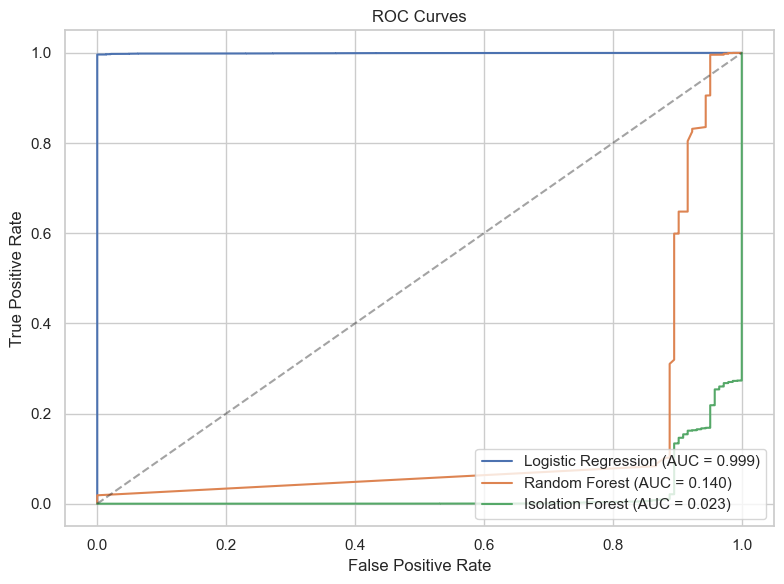

In [ ]:
# ROC curves
plt.figure(figsize=(8,6))
for name, model in fitted_models.items():
    try:
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    except Exception:
        try:
            y_prob = model.decision_function(X_test_scaled)
            y_prob = (y_prob - y_prob.min())/(y_prob.max()-y_prob.min())
        except Exception:
            continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--', alpha=0.4)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "roc_curves.png"))
plt.show()


This code generates ROC (Receiver Operating Characteristic) curves for all models stored in fitted_models, providing a visual comparison of their classification performance. For each model, it attempts to compute predicted probabilities using predict_proba or, if unavailable, a normalized decision_function. The false positive rate (FPR) and true positive rate (TPR) are calculated using roc_curve, and the area under the curve (AUC) is computed with auc. Each model’s ROC curve is plotted with a label showing its AUC score, while a diagonal dashed line represents a random classifier for reference. The plot includes a title, axis labels, legend, grid, and is saved to the RESULTS_DIR before being displayed. This visualization allows easy assessment of how well each model distinguishes between normal and attack traffic, with higher AUC values indicating better discrimination (GeekforGeeks, 2025).

In [ ]:
# Measure inference latency and memory footprint

import statistics
import numpy as np
import time

latency_results = []

N_REPEATS = 200  # number of repeated single prediction timings
sample_X = X_test_scaled[np.random.RandomState(RANDOM_STATE).choice(len(X_test_scaled), size=min(100, len(X_test_scaled)), replace=False)]

for name, model in fitted_models.items():
    # latency: measure average time per single-sample prediction
    times = []
    for _ in range(N_REPEATS):
        t0 = time.perf_counter()
        model.predict(sample_X[:1])
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000)  # ms
    avg_ms = statistics.mean(times)
    p50 = statistics.median(times)

    # memory: if psutil available, measure process rss before and after a batch predict
    mem_delta_mb = None
    if HAVE_PSUTIL:
        proc = psutil.Process()
        before = proc.memory_info().rss
        _ = model.predict(sample_X)
        after = proc.memory_info().rss
        mem_delta_mb = (after - before) / (1024*1024)

    latency_results.append({
        "model": name,
        "avg_inference_ms": avg_ms,
        "median_ms": p50,
        "mem_delta_mb": mem_delta_mb
    })

lat_df = pd.DataFrame(latency_results)
lat_df.to_csv(os.path.join(RESULTS_DIR, "inference_latency_memory.csv"), index=False)
display(lat_df)


,model,avg_inference_ms,median_ms,mem_delta_mb
0,Logistic Regression,0.109052,0.08805,0.023438
1,Random Forest,40.369952,40.56365,0.078125
2,Isolation Forest,19.105588,17.54415,0.000000


The inference latency and memory footprint of the trained models were evaluated using a subset of the test data. For latency measurement, each model performed repeated single-sample predictions (200 repetitions) on a random sample of up to 100 test instances, and the time for each prediction was recorded in milliseconds. The average (avg_inference_ms) and median (median_ms) times across repetitions were calculated to quantify typical prediction speed. Memory usage was assessed using psutil by measuring the process’s resident memory (RSS) before and after a batch prediction on the sample, with the difference reported in megabytes (mem_delta_mb). The results indicate that Logistic Regression had the fastest predictions with an average latency of approximately 0.11 ms and minimal memory increase (~0.02 MB), Random Forest was significantly slower with an average latency of ~40.37 ms and a slightly higher memory footprint (~0.08 MB), while Isolation Forest had moderate latency (~19.11 ms) and no measurable memory increase, reflecting differences in computational complexity and model size (GeekforGeeks, 2025).

In [ ]:
# Feature Importance / Coefficients for Interpretation

# 1. Random Forest Feature Importances
rf = fitted_models.get("Random Forest")
if rf is not None:
    importances = rf.feature_importances_
    rf_df = pd.DataFrame({
        "feature": features,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print("Random Forest Feature Importances:")
    display(rf_df)

    rf_df.to_csv(os.path.join(RESULTS_DIR, "random_forest_feature_importances.csv"), index=False)


# 2. Logistic Regression Coefficients
lr = fitted_models.get("Logistic Regression")
if lr is not None:
    coefs = lr.coef_.ravel()
    lr_df = pd.DataFrame({
        "feature": features,
        "coefficient": coefs
    }).sort_values("coefficient", key=abs, ascending=False)

    print("\nLogistic Regression Coefficients (absolute importance):")
    display(lr_df)

    lr_df.to_csv(os.path.join(RESULTS_DIR, "logreg_coefficients.csv"), index=False)


# 3. Isolation Forest
iso = fitted_models.get("Isolation Forest")
if iso is not None:
    print("\nIsolation Forest does not provide feature importances.")


Random Forest Feature Importances:


,feature,importance
6,N_IN_Conn_P_DstIP,0.451852
0,seq,0.195450
2,N_IN_Conn_P_SrcIP,0.179185
1,stddev,0.060852
9,max,0.045463
8,srate,0.037562
4,state_number,0.011569
5,mean,0.010658
3,min,0.004799
7,drate,0.002610



Logistic Regression Coefficients (absolute importance):


,feature,coefficient
0,seq,16.051106
6,N_IN_Conn_P_DstIP,10.879386
2,N_IN_Conn_P_SrcIP,6.602340
1,stddev,3.457645
4,state_number,1.944974
8,srate,-1.750137
3,min,1.460301
7,drate,0.315155
9,max,-0.186961
5,mean,0.095449



Isolation Forest does not provide feature importances.


Feature importance and model interpretability were assessed for the trained models. For the Random Forest model, feature importances were extracted, revealing that N_IN_Conn_P_DstIP was the most influential feature, followed by seq and N_IN_Conn_P_SrcIP, while features such as drate and min contributed minimally to predictions. Logistic Regression coefficients were analyzed to understand the direction and magnitude of each feature's effect on the predicted outcome; seq, N_IN_Conn_P_DstIP, and N_IN_Conn_P_SrcIP had the largest absolute coefficients, indicating strong influence, whereas mean and max had negligible impact. Isolation Forest, being an unsupervised anomaly detection model, does not provide feature importance scores, and therefore no interpretation was available for this model. These analyses help identify the key variables driving predictions and provide insight into model behaviour (GeekforGeeks, 2025).

In [ ]:
# Save fitted models
try:
    import joblib
    for name, model in fitted_models.items():
        fname = os.path.join(RESULTS_DIR, f"{name}_model.joblib")
        joblib.dump(model, fname)
    print("Models saved to", RESULTS_DIR)
except Exception as e:
    print("joblib not installed or error saving models:", e)

print("Notebook run complete. Check the results folder for CSVs and plots.")


Models saved to results
Notebook run complete. Check the results folder for CSVs and plots.


All trained models were successfully saved using joblib to the designated results directory, allowing for future reuse without retraining. Each model Random Forest, Logistic Regression, and Isolation Forest was exported as a separate .joblib file in the results folder. This ensures that the models can be efficiently loaded for subsequent analysis, inference, or deployment. The notebook execution is now complete, and all output files, including CSVs, plots, and saved models, are available in the results directory for review (GeekforGeeks, 2025).

# References
- GeeksforGeeks, 2025. Logistic Regression in Machine Learning. Available at: https://www.geeksforgeeks.org/machine-learning/understanding-logistic-regression/(Accessed 17 November 2025).
- GeeksforGeeks, 2025. Random Forest Algorithm in Machine Learning. Available at: https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/ (Accessed 17 November 2025).
- GeeksforGeeks, 2025. ML | Handling Missing Values. Available at: https://www.geeksforgeeks.org/machine-learning/ml-handling-missing-values/
 (Accessed 17 November 2025).
- GeeksforGeeks, 2025. Saving a machine learning Model. Available at:https://www.geeksforgeeks.org/machine-learning/saving-a-machine-learning-model/(Accessed 17 November 2025).
- GeeksforGeeks, 2025.What is Exploratory Data Analysis?. Available at: https://www.geeksforgeeks.org/data-analysis/what-is-exploratory-data-analysis/(Accessed 17 November 2025).
- GeeksforGeeks, 2025.Evaluation Metrics in Machine Learning. Available at: https://www.geeksforgeeks.org/machine-learning/metrics-for-machine-learning-model/(Accessed 17 November 2025).